In [14]:
import pandas as pd
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from label_map import label2id, id2label

## 1 뉴스 본문 전처리, 요약, 종목명, 업종명, 임베딩

### 1 뉴스 본문 전처리

In [15]:
df = pd.read_csv("../../db/news_2023_2025.csv")

In [ ]:
# wdate를 datetime으로 변환 (이미 되어 있다면 생략 가능)
df["wdate"] = pd.to_datetime(df["wdate"], errors="coerce")

# 평일(월=0 ~ 금=4)만 필터링
df = df[df["wdate"].dt.weekday < 5].copy()

In [16]:
df.head(2)

,news_id,wdate,title,article,press,url,image
0,20250523_0001,2025-05-23 19:11,[마켓인]모태펀드 존속 불확실성 해소될까…이재명 공약에 업계 주목,"2035년 종료 앞둬, 존속 공약에 기대감\n창업 초기자금 공백 완화 가능성에 업계...",이데일리,https://n.news.naver.com/mnews/article/018/000...,https://imgnews.pstatic.net/image/018/2025/05/...
1,20250523_0002,2025-05-23 18:52,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...


In [24]:
import re
from kss import split_sentences

def remove_market_related_sentences(text: str) -> str:
    # 줄바꿈 제거
    text = text.replace("\n", " ")

    # 대괄호 포함 텍스트 제거: [파이낸셜뉴스], [사진] 등
    text = re.sub(r"\[[^\]]*\]", "", text)

    # '/사진', '/사진제공' 제거
    text = re.sub(r"/사진(제공)?", "", text)

    # 이메일 주소 제거 (예: josh@yna.co.kr)
    text = re.sub(r"\b[\w.-]+@[\w.-]+\.\w+\b", "", text)

    # 문장 단위 분리 (간단하게 마침표 기준, 필요시 KSS 등 적용 가능)
    sentences = split_sentences(text)

    # 제거할 패턴들 (뉴스 문장에서 자주 등장하는 패턴)
    patterns = [
        r"(자세한 내용|자세한 사항)",  # 뉴스 기본 표현
        r"\d{4}[.-]\d{1,2}[.-]\d{1,2}",  # 날짜 (예: 2025.03.26, 2024-12-01)
        r"([0-9,]+(?:만)?[0-9,]*\s?(?:원|만원))",  # 가격 (예: 3,500원, 12000원)
        r"(강세|펀드|시가총액|등락률|한국거래소)",  # 증시 용어
        r"\([+-]?[0-9.,]+%\)",  # 괄호 안 퍼센트 등락률
        r"(투자의견|연구원|평가|예상치|증권가|리포트|팀장)",  # 애널리스트 용어
        r"(순이익|전년|매출|영업이익|영업적자|증시|코스피|코스닥|다우|나스닥|매출액|거래일|호조세|레버리지|투자자|조정|자산|수익률|이익률|수익성|내리막|부진한|낙폭|기대치|실적발표|기업 가치)",  # 시장 용어
    ]

    # 하나의 통합 패턴으로 컴파일
    combined_pattern = re.compile("|".join(patterns))

    # 필터링된 문장만 유지
    filtered = [s for s in sentences if not combined_pattern.search(s)]

    text_preprocessed = " ".join(filtered)

    # print(f"원문:{sentences}\n|\n전처리 된 문장: {text_preprocessed}\n\n")

    return text_preprocessed

In [25]:
from tqdm import tqdm

tqdm.pandas()  # 이거 반드시 호출해야 함

df["article_preprocessed"] = df[
    "article"
].progress_apply(remove_market_related_sentences)

100%|██████████| 58405/58405 [28:07<00:00, 34.61it/s]  


In [30]:
def drop_article_preprocessed(df):
    # 전처리된 문장 길이 구하기
    df["article_preprocessed_len"] = df[
        "article_preprocessed"
    ].apply(lambda x: len(x))

    # 전처리된 문장 길이가 70 이상인 것만 필터링
    df = df[
        df["article_preprocessed_len"] > 70
    ]

    df = df.drop(columns=["article_preprocessed_len"])

    return df

In [31]:
df = drop_article_preprocessed(df)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53202 entries, 0 to 58404
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   news_id               53202 non-null  object
 1   wdate                 53202 non-null  object
 2   title                 53202 non-null  object
 3   article               53202 non-null  object
 4   press                 53202 non-null  object
 5   url                   53202 non-null  object
 6   image                 53202 non-null  object
 7   article_preprocessed  53202 non-null  object
dtypes: object(8)
memory usage: 3.7+ MB


### 2 뉴스 본문 요약

In [20]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 모델 이름
model_summarize_name1 = "digit82/kobart-summarization"

# 토크나이저 & 모델 로드
tokenizer_summarize1 = AutoTokenizer.from_pretrained(model_summarize_name1)
model_summarize1 = AutoModelForSeq2SeqLM.from_pretrained(
    model_summarize_name1, use_safetensors=True
)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_summarize1.to(device)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

In [33]:
def summarize_event_focused(text):
    # 토크나이징 및 텐서 변환 (GPU로 올리기)
    inputs = tokenizer_summarize1(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    input_ids = inputs["input_ids"].to(device)

    text_length = len(text)

    # 1. 최소 길이는 짧은 본문은 고정, 긴 본문은 점진적으로 증가
    def compute_min_length(text_length: int) -> int:
        if text_length < 300:
            return 30
        else:
            return 50

    min_len = compute_min_length(text_length)
    max_len = round(text_length * 0.5) + 50  # 더 여유를 주되 max 길이 제한

    # 2. generate 최적 설정
    summary_ids = model_summarize1.generate(
        input_ids,
        min_length=min_len,
        max_new_tokens=max_len,
        num_beams=4,  # 4보다 빠름. 품질도 비슷
        length_penalty=1.0,  # 길이 패널티 완화
        repetition_penalty=1.3,  # 반복 억제 강화
        no_repeat_ngram_size=3,  # 반복 문장 방지
        early_stopping=True,
        do_sample=False,  # 일관된 요약
    )

    return tokenizer_summarize1.decode(summary_ids[0], skip_special_tokens=True)


def print_summary(df, max_tokens=128):
    for i, row in tqdm(df.iterrows(), total=len(df)):
        try:
            text = row["article_preprocessed"]
            summary = summarize_event_focused(text)
            print(f"\n📝 뉴스 {i}\n\n본문: {text} \n\n요약: {summary}\n")
        except Exception as e:
            print(f"❌ 요약 실패: {e}")

In [34]:
print_summary(df[:3])

 33%|███▎      | 1/3 [00:04<00:09,  4.57s/it]


📝 뉴스 0

본문: 2035년 종료 앞둬, 존속 공약에 기대감 창업 초기자금 공백 완화 가능성에 업계 안도 VC, "정책 연속성 중요…불확실성 줄어야" 퇴직연금도 벤처로…BDC 등 활성화 방안 포함 이 기사는 2025년05월23일 17시10분에 마켓인 프리미엄 콘텐츠 로 선공개 되었습니다. 23일 관련업계에 따르면 이 후보는 해당 공약을 ‘벤처·스타트업 10대 공약’의 하나로 포함시키며, 벤처 투자 인프라를 제도적으로 보완하겠다는 의지를 내비쳤다. 업계에서는 단기 예산 복원이 아닌, 정책 연속성에 무게를 둔 점에 주목하고 있다. 글로벌 대비 민간 자본의 투자 여력이 제한적인 한국 벤처 시장 특성상, 정부 출자의 존재감은 그만큼 절대적이다. 이에 따라 벤처캐피털(VC) 업계에서는 이재명 후보의 공약이 단순한 예산 복원을 넘어 구조적인 불확실성 해소에 방점을 두고 있다는 점에서 긍정적으로 받아들이는 분위기다. 이 후보는 이외에도 퇴직연금의 벤처투자 허용, 연기금 투자풀의 벤처투자 확대, 기업 성장집합투자기구(BDC) 도입 등 다양한 벤처투자 활성화 방안을 함께 제시하며 투자 생태계 전반의 구조 개편 의지를 밝혔다. 

요약: 이재명 후보의 벤처투자 허용, 연기금 투자풀의 벤처투자 확대, 기업 성장집합투자기구(BDC) 도입 등 다양한 벤처투자 활성화 방안을 함께 제시하며 투자 생태계 전반의 구조 개편 의지를 내비쳤다.   



 67%|██████▋   | 2/3 [00:06<00:02,  2.82s/it]


📝 뉴스 1

본문: 매각가 5000억 안팎 달할듯 결제시장 내 입지강화 포석 카카오페이  국내 대표 전자결제사업자인 카카오페이가 신세계이마트 산하 간편결제사업부 인수에 나섰다. 네이버페이·토스페이에 대항해 시장 점유율을 늘리려는 포석으로 해석된다. 23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이와 G마켓 스마일페이 인수를 위해 신세계이마트 측과 협상을 진행 중인 것으로 파악됐다. 업계에서는 매각가가 5000억원 안팎에 달할 것으로 전망했다. 카카오페이는 약 2500만명의 이용자를 보유한 쓱페이·스마일페이를 인수할 경우 사업 외연을 확대할 수 있다. 매각 작업에 정통한 업계 고위 관계자는 “카카오페이가 결제시장 내 입지 강화를 위해 신세계이마트와 결제사업 부문 인수 등 다양한 방안에 대해 논의 중인 것으로 안다”고 전했다. 신세계이마트 측은 “매각을 재추진중인 건 맞지만 아직 정해진 것은 없다”고 밝혔다. 신세계이마트는 지난 해 토스와 결제사업 매각을 논의하다 결렬된 바 있다. 

요약: 23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카카오페이가 SSG닷컴 쓱페이와 G마켓 스마일페이 인수를 위해 신세계이마트 측과 협상을 진행 중인 것으로 알려졌다.



100%|██████████| 3/3 [00:07<00:00,  2.35s/it]


📝 뉴스 2

본문: 총 2166대1의 경쟁률을 기록, 청약 증거금 6조원을 모으는 데 성공했다. 지난 22일부터 이날까지 양간 일반 청약을 진행한 결과 최종 경쟁률은 총 2166.01대1로  집계됐다. 청약 건수는 19만1049건으로, 청약 금액의 절반을 미리 내는 청약증거금은 약 6조1400억원이 모였다. 키스트론은 고려제강그룹 계열사로 1992년 설립됐다. 철선에 구리를 도금한 동복강선 리드 와이어가 핵심 제품으로, 글로벌 시장에서 약 18% 점유율을 갖췄다. 이번 공모를 통해 226억 원을 조달한다. 주관사는 신한투자증권이 맡았다. 

요약: 고려제강그룹 계열사로 1992년 설립된 키스트론은 지난 22일부터 양간 일반 청약을 진행한 결과 최종 경쟁률은 총 2166.01대1로 집계됐다.



In [37]:
df = df[:20000]

In [38]:
df["summary"] = df[
    "article_preprocessed"
].progress_apply(summarize_event_focused)

100%|██████████| 20000/20000 [8:47:08<00:00,  1.58s/it]  


### 3 뉴스 종목 매칭하기

In [21]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from label_map import label2id, id2label

model_name = "KPF/KPF-BERT-NER"

# 토크나이저와 모델 불러오기
tokenizer_ner = AutoTokenizer.from_pretrained(model_name)
model_ner = AutoModelForTokenClassification.from_pretrained(
    model_name, use_safetensors=True
)

# 라벨 매핑 반영
model_ner.config.label2id = label2id
model_ner.config.id2label = id2label

tokenizer_ner.model_max_length = 512

# 디바이스 설정
device = 0 if torch.cuda.is_available() else -1

# NER 파이프라인 생성 (GPU 사용)
ner_pipeline = pipeline(
    task="ner",
    model=model_ner,
    tokenizer=tokenizer_ner,
    aggregation_strategy="simple",
    framework="pt",
    device=device,
)

Device set to use cpu


In [39]:
def extract_ner(text):
    entities = ner_pipeline(text)
    results = []
    seen = set()

    for ent in entities:
        word = ent["word"].replace("##", "").strip()
        tag = ent["entity_group"]

        score = ent["score"]

        if word and score >= 0.95 and (word, tag) not in seen:
            results.append((word, tag))
            seen.add((word, tag))

    return results


def get_stock_names(text):
    ner_list = extract_ner(text)

    # OGG_ECONOMY만 필터링하여 종목명만 리스트로 추출
    stock_names = [ent[0] for ent in ner_list if ent[1] == "OGG_ECONOMY"]

    return stock_names

In [40]:
df["stock_list"] = df["summary"].progress_apply(
    get_stock_names
)

100%|██████████| 20000/20000 [19:09<00:00, 17.40it/s]


In [41]:
# 종목명이 1개 이상, 4개 이하인 뉴스만 필터링하기

df["stock_list_len"] = df["stock_list"].apply(lambda x: len(x))

df = df[(df["stock_list_len"] >= 1) & (df["stock_list_len"] <= 4)]

df = df.drop(columns=["stock_list_len"])

In [ ]:
df_krx_desc2 = pd.read_csv("../../db/KRX_KOSPI.csv", encoding="cp949")
stock_all_list = df_krx_desc2["종목명"].tolist()

In [ ]:
import ast

# stock_list 컬럼을 필터링
def filter_official_stocks(stock_list):
    return [stock for stock in ast.literal_eval(stock_list) if stock in stock_all_list]

# 적용
df["stock_list"] = df["stock_list"].apply(filter_official_stocks)

### 4 뉴스 업종명 매칭하기

In [42]:
df_krx_desc = pd.read_csv("../../db/kospi_description.csv", encoding="cp949")
df_krx_desc.head()

,종목코드,종목명,시장구분,소속부,소속부.1,업종코드,업종명,결산월,지정자문인,상장주식수,액면가,자본금,통화구분,대표이사,대표전화,주소
0,95570,AJ네트웍스,KOSPI,NaN,NaN,147603,산업용 기계 및 장비 임대업,12,NaN,45252759,1000,46822295000,원(KRW),곽정호,02-6363-9999,"서울특별시 송파구 정의로8길 9 (문정동,AJ빌딩)"
1,6840,AK홀딩스,KOSPI,NaN,NaN,116409,기타 금융업,12,NaN,13247561,5000,66237805000,원(KRW),"고준, 채형석 (각자 대표이사)",02-768-2923,서울특별시 마포구 양화로 188 -
2,27410,BGF,KOSPI,NaN,NaN,116409,기타 금융업,12,NaN,95716791,1000,95716791000,NaN,홍정국,1577-3663,서울특별시 강남구 테헤란로 405
3,282330,BGF리테일,KOSPI,NaN,NaN,74701,종합 소매업,12,NaN,17283906,1000,17283906000,원(KRW),민승배,02-1577-8007,서울특별시 강남구 테헤란로 405 BGF사옥
4,138930,BNK금융지주,KOSPI,NaN,NaN,116409,기타 금융업,12,NaN,318383519,5000,1629676230000,원(KRW),빈대인,051-620-3023,부산광역시 남구 문현금융로 30(문현동)


In [43]:
# 종목명 → 업종명 매핑 딕셔너리 생성
stock_to_industry = dict(zip(df_krx_desc["종목명"], df_krx_desc["업종명"]))

# 업종명을 리스트로 매핑
def get_industry_list(stock_list):
    return [
        stock_to_industry.get(stock, "")
        for stock in stock_list
        if stock_to_industry.get(stock, "") != ""
    ]

# 새로운 컬럼에 저장
df["industry_list"] = df["stock_list"].apply(get_industry_list)

In [44]:
# 업종명이 1개 이상인 뉴스만 필터링하기

df["industry_list_len"] = df["industry_list"].apply(lambda x: len(x))

df = df[df["industry_list_len"] >= 1]

df = df.drop(columns=["industry_list_len"])

### 5 뉴스 요약문 임베딩하기

In [22]:
from sentence_transformers import SentenceTransformer
import torch

model_name = "snunlp/KR-SBERT-V40K-klueNLI-augSTS"

# GPU가 있으면 GPU, 없으면 CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# 모델 로딩 후 디바이스 설정
model_emb = SentenceTransformer(model_name, device=device)

In [ ]:
embeddings = model_emb.encode(
    df["summary"].tolist(), show_progress_bar=True
)

df["summary_embedding"] = embeddings.tolist()

In [45]:
df.to_csv("../../db/news_2023_2025_summarized.csv")

In [46]:
df_summarized = pd.read_csv(('../../db/news_2023_2025_summarized.csv'))
df_summarized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5419 entries, 0 to 5418
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            5419 non-null   int64 
 1   news_id               5419 non-null   object
 2   wdate                 5419 non-null   object
 3   title                 5419 non-null   object
 4   article               5419 non-null   object
 5   press                 5419 non-null   object
 6   url                   5419 non-null   object
 7   image                 5419 non-null   object
 8   article_preprocessed  5419 non-null   object
 9   summary               5419 non-null   object
 10  stock_list            5419 non-null   object
 11  industry_list         5419 non-null   object
dtypes: int64(1), object(11)
memory usage: 508.2+ KB


### 6 뉴스 유사도 상위 Top-N개 데이터셋 구성

In [154]:
df_summarized = pd.read_csv("../../db/news_2023_2025_summarized.csv")
# df_summarized = df_summarized.drop(columns=["title", "article", "article_preprocessed", 'url', 'image', 'press'])

In [155]:
df_summarized.head()

,news_id,wdate,title,article,press,url,image,article_preprocessed,summary,stock_list,industry_list,summary_embedding
0,20250523_0002,2025-05-23 18:52,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,매각가 5000억 안팎 달할듯 결제시장 내 입지강화 포석 카카오페이 국내 대표 전...,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],"[-0.21889664232730865, -1.4778014421463013, 0...."
1,20250523_0004,2025-05-23 18:33,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다",[사진=연합뉴스]\n세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,['삼성전자'],['통신 및 방송 장비 제조업'],"[-0.2798689603805542, -0.5640878081321716, -0...."
2,20250523_0007,2025-05-23 18:00,[단독] 전자결제 강자 카카오페이 쓱·스마일 페이 인수 추진,국내 대표 전자결제사업자인 카카오페이가 신세계이마트 산하 간편결제사업부 인수에 나섰...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://ssl.pstatic.net/static.news/image/news...,국내 대표 전자결제사업자인 카카오페이가 신세계이마트 산하 간편결제사업부 인수에 나섰...,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이...,['카카오페이'],['금융 지원 서비스업'],"[-0.5892677903175354, -1.0036863088607788, 0.3..."
3,20250523_0010,2025-05-23 17:52,조현준 효성重 지분 4.9% 美 테크펀드 2600억 매각,조현준 효성 회장이 상속세 재원 마련을 위해 효성중공업 지분 4.90%를 미국의 글...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://ssl.pstatic.net/static.news/image/news...,효성중공업은 조 회장이 상속세 재원을 마련하기 위해 시간 외 매매로 효성중공업 주식...,23일 효성중공업은 조 회장이 상속세 재원을 마련하기 위해 시간 외 매매로 효성중 ...,['효성중공업'],"['전동기, 발전기 및 전기 변환 · 공급 · 제어 장치 제조업']","[-0.326259970664978, -0.49666550755500793, -0...."
4,20250523_0011,2025-05-23 17:52,몸집 키우는 카카오…'간편결제 빅3' 흔드나,"카카오페이, 신세계 페이 품나\n이커머스 결제 강화 점유 확대\n압도적 1위 네이버...",매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"카카오페이, 신세계 페이 품나 이커머스 결제 강화 점유 확대 압도적 1위 네이버에 ...",카카오페이가 신세계 이마트 측에서 쓱페이·스마일페이 인수를 추진하고 나선 건 국내 ...,['카카오페이'],['금융 지원 서비스업'],"[-0.771115779876709, -1.174679160118103, -0.27..."


In [156]:
# 주말 제거

df_summarized["wdate"] = pd.to_datetime(df_summarized["wdate"], errors="coerce")

df_summarized = df_summarized[df_summarized["wdate"].dt.weekday < 5].copy()

In [157]:
df_summarized.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14087 entries, 0 to 14811
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   news_id               14087 non-null  object        
 1   wdate                 14087 non-null  datetime64[ns]
 2   title                 14087 non-null  object        
 3   article               14087 non-null  object        
 4   press                 14087 non-null  object        
 5   url                   14087 non-null  object        
 6   image                 14087 non-null  object        
 7   article_preprocessed  14087 non-null  object        
 8   summary               14087 non-null  object        
 9   stock_list            14087 non-null  object        
 10  industry_list         14087 non-null  object        
 11  summary_embedding     14087 non-null  object        
dtypes: datetime64[ns](1), object(11)
memory usage: 1.4+ MB


In [158]:
df_summarized.to_csv("../../db/news_2023_2025_summarized.csv", index=False)

In [136]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from datetime import timedelta
import ast  # 안전한 문자열 → 파이썬 객체 변환

df_summarized["summary_embedding"] = df_summarized["summary_embedding"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# 1. 코사인 유사도 계산
embeddings = np.vstack(df_summarized["summary_embedding"].to_numpy())
similarity_matrix = cosine_similarity(embeddings)

df_summarized["wdate"] = pd.to_datetime(df_summarized["wdate"], errors="coerce")

def extract_top5_similars_with_time_filter(base_idx):
    base_row = df_summarized.iloc[base_idx]
    base_date = base_row["wdate"]

    sims = similarity_matrix[base_idx].copy()
    sims[base_idx] = -1  # 자기 자신 제외

    # 조건 1: 기준 뉴스보다 3개월(90일) 이상 과거
    mask_date_gap = df_summarized["wdate"] < (base_date - timedelta(days=90))
    valid_indices = np.where(mask_date_gap)[0]

    # 유효한 인덱스만 추림
    sims_filtered = [(idx, sims[idx]) for idx in valid_indices]
    sims_sorted = sorted(sims_filtered, key=lambda x: x[1], reverse=True)

    selected_rows = []
    selected_dates = []

    for idx, sim in sims_sorted:
        candidate_date = df_summarized.iloc[idx]["wdate"]

        # 조건 2: 기존 선택된 유사 뉴스들과 1개월(30일) 이상 시차
        if all(abs((candidate_date - d).days) >= 30 for d in selected_dates):
            similar_row = df_summarized.iloc[idx]
            row_data = base_row.to_dict()
            row_data.update(
                {
                    "similarity": sim,
                    "similar_news_id": similar_row["news_id"],
                    "similar_wdate": similar_row["wdate"],
                    "similar_summary": similar_row["summary"],
                    "similar_stock_list": similar_row["stock_list"],
                    "similar_industry_list": similar_row["industry_list"],
                }
            )
            selected_rows.append(row_data)
            selected_dates.append(candidate_date)

        if len(selected_rows) == 5:
            break

    return selected_rows


# 3. 전체 반복
all_rows = []
for i in tqdm(range(len(df_summarized)), total=len(df_summarized)):
    all_rows.extend(extract_top5_similars_with_time_filter(i))

df_final = pd.DataFrame(all_rows)

100%|██████████| 14087/14087 [06:31<00:00, 36.02it/s]  


In [140]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45699 entries, 0 to 45698
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   news_id                45699 non-null  object        
 1   wdate                  45699 non-null  datetime64[ns]
 2   summary                45699 non-null  object        
 3   stock_list             45699 non-null  object        
 4   industry_list          45699 non-null  object        
 5   summary_embedding      45699 non-null  object        
 6   similarity             45699 non-null  float64       
 7   similar_news_id        45699 non-null  object        
 8   similar_wdate          45699 non-null  datetime64[ns]
 9   similar_summary        45699 non-null  object        
 10  similar_stock_list     45699 non-null  object        
 11  similar_industry_list  45699 non-null  object        
 12  is_similar_stock       45699 non-null  int64         
 13  i

In [138]:
df_final[:10]

,news_id,wdate,summary,stock_list,industry_list,summary_embedding,similarity,similar_news_id,similar_wdate,similar_summary,similar_stock_list,similar_industry_list
0,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],"[-0.21889664232730865, -1.4778014421463013, 0....",0.654728,20240429_0061,2024-04-29 16:15:00,29일 투자은행 업계에 따르면 티빙 웨이브의 모회사인 CJ ENM과 SK스퀘어의 티...,['SK스퀘어'],['기타 금융업']
1,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],"[-0.21889664232730865, -1.4778014421463013, 0....",0.653166,20250217_0114,2025-02-17 08:30:00,카카오페이가 상장사 중 첫 사례인 만큼 핀테크 턴어라운드 중요성을 점차 인식하는 구...,"['카카오페이', '카카오']","['금융 지원 서비스업', '자료처리, 호스팅, 포털 및 기타 인터넷 정보매개 서비..."
2,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],"[-0.21889664232730865, -1.4778014421463013, 0....",0.653037,20241022_0265,2024-10-22 08:37:00,유안타증권은 22일 국내 보안기업 라온시큐어가 딥페이크와 모바일 신분증 사업을 본격...,['유안타증권'],['금융 지원 서비스업']
3,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],"[-0.21889664232730865, -1.4778014421463013, 0....",0.646287,20240228_0063,2024-02-28 16:16:00,28일 진행된페이증권 이사회에서 신호철 현 카카오페이 사업개발실장이 카카오페이증권 ...,['카카오페이'],['금융 지원 서비스업']
4,20250523_0002,2025-05-23 18:52:00,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,['카카오페이'],['금융 지원 서비스업'],"[-0.21889664232730865, -1.4778014421463013, 0....",0.645620,20240614_0253,2024-06-14 07:46:00,최근 CJ대한통운은 신세계 그룹과 물류 협력을 추진하기로 하면서 G마켓과 SSG.c...,"['CJ대한통운', '이마트']","['도로 화물 운송업', '종합 소매업']"
5,20250523_0004,2025-05-23 18:33:00,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,['삼성전자'],['통신 및 방송 장비 제조업'],"[-0.2798689603805542, -0.5640878081321716, -0....",0.711211,20240919_0004,2024-09-19 18:35:00,19일 미래에셋증권이 지난 7월 아시아 금융인 최초로 그룹 박현주 회장이 국제경영학...,['미래에셋증권'],['금융 지원 서비스업']
6,20250523_0004,2025-05-23 18:33:00,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,['삼성전자'],['통신 및 방송 장비 제조업'],"[-0.2798689603805542, -0.5640878081321716, -0....",0.677151,20240523_0065,2024-05-23 15:30:00,23일 NH투자증권은 여의도 페어몬트 앰버서더 서울 호텔에서 'C-레벨(C-LEVE...,['NH투자증권'],['금융 지원 서비스업']
7,20250523_0004,2025-05-23 18:33:00,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,['삼성전자'],['통신 및 방송 장비 제조업'],"[-0.2798689603805542, -0.5640878081321716, -0....",0.676038,20240308_0041,2024-03-08 15:56:00,"NH투자증권이 임원후보추천위원회를 열어 유찬형 전 농협중앙회 부회장, 윤병운 NH투...","['NH투자증권', '삼성증권']","['금융 지원 서비스업', '금융 지원 서비스업']"
8,20250523_0004,2025-05-23 18:33:00,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,['삼성전자'],['통신 및 방송 장비 제조업'],"[-0.2798689603805542, -0.5640878081321716, -0....",0.671668,20250220_0059,2025-02-20 13:16:00,20일 투자은행(IB)업계에 따르면 국내 1위 금융정보분석 제공업체인 에프앤가이드가...,['삼성증권'],['금융 지원 서비스업']
9,20250523_0004,2025-05-23 18:33:00,세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드...,['삼성전자'],['통신 및 방송 장비 제조업'],"[-0.2798689603805542, -0.5640878081321716, -0....",0.668840,20240206_0205,2024-02-06 09:27:00,2019년 말 국내 기관투자가가 주축이 돼 출범한 민간단체로 기업 지배구조 개선 논...,"['삼성전자', 'LG화학']","['통신 및 방송 장비 제조업', '기초 화학물질 제조업']"


In [147]:
def has_overlap(list1, list2):
    list1 = ast.literal_eval(list1)
    list2 = ast.literal_eval(list2)

    return int(bool(set(list1) & set(list2)))  # 교집합 존재 여부를 1 또는 0으로 반환

# 적용
df_final["is_similar_stock"] = df_final.apply(
    lambda row: has_overlap(row["stock_list"], row["similar_stock_list"]), axis=1
)

df_final["is_simliar_industry"] = df_final.apply(
    lambda row: has_overlap(row["industry_list"], row["similar_industry_list"]), axis=1
)

In [148]:
df_final.columns

Index(['news_id', 'wdate', 'summary', 'stock_list', 'industry_list',
       'similarity', 'is_similar_stock', 'is_simliar_industry',
       'similar_news_id', 'similar_wdate', 'similar_summary',
       'similar_stock_list', 'similar_industry_list'],
      dtype='object')

In [149]:
df_final = df_final[
    [
        "news_id",
        "wdate",
        "summary",
        "stock_list",
        "industry_list",
        "similarity",
        "is_similar_stock",
        "is_simliar_industry",
        "similar_news_id",
        "similar_wdate",
        "similar_summary",
        "similar_stock_list",
        "similar_industry_list",
    ]
]

<Axes: xlabel='similarity', ylabel='Count'>

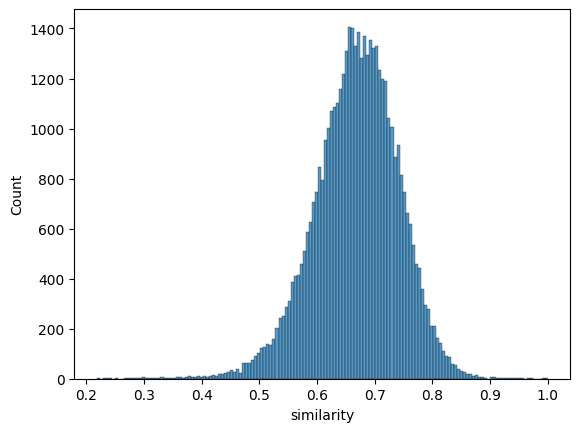

In [162]:
sns.histplot(df_final["similarity"])

In [168]:
df_final['similarity'].describe()

count    45699.000000
mean         0.668304
std          0.072875
min          0.218509
25%          0.623374
50%          0.671540
75%          0.717614
max          1.000000
Name: similarity, dtype: float64

In [164]:
# 전체 컬럼 내용 출력 제한 해제
pd.set_option("display.max_colwidth", None)

In [172]:
df_final.sort_values(by='similarity', ascending=False)[20:40]

,news_id,wdate,summary,stock_list,industry_list,similarity,is_similar_stock,is_simliar_industry,similar_news_id,similar_wdate,similar_summary,similar_stock_list,similar_industry_list
14123,20250210_0077,2025-02-10 11:32:00,10일 교보증권 교보증권은 오는 13일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 10일 밝혔으며 중도 상환 시 원금손실이 발생할 수 있어 ELB 1종 공모를 진행한다고 밝혔다.,['교보증권'],['금융 지원 서비스업'],0.929770,1,1,20240530_0163,2024-05-30 10:47:00,30일 교보증권 교보증권은 다음달 7일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 30일 밝혔으며 중도 상환 시 원금손실이 발생할 수 있는 원금 손실이 발생할 수도 있다고 전했다.,['교보증권'],['금융 지원 서비스업']
18061,20250108_0105,2025-01-08 09:08:00,교보증권이 오는 10일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 8일 밝혔으며 6개월마다 조기상환 기회를 부여하며 중도상환시 원금손실이 발생할 수 있다.,['교보증권'],['금융 지원 서비스업'],0.923575,1,1,20241004_0135,2024-10-04 10:07:00,4일 교보증권 교보증권은 오는 11일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 4일 밝혔으며 중도상환시 원금손실이 발생할 수 있어 ELB 1종에 대해 공모한다고 밝혔다.,['교보증권'],['금융 지원 서비스업']
32890,20240919_0139,2024-09-19 10:06:00,교보증권 교보증권은 오는 27일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 19일 밝혔으며 중도상환시 원금손실이 발생할 수 있어 ELB 1종에 대해 공모한다고 밝혔다.,['교보증권'],['금융 지원 서비스업'],0.921648,1,1,20240418_0118,2024-04-18 13:54:00,18일 교보증권 교보증권은 오는 26일까지 세전 최대 연 6.0% 수익의 주가연계파생결합사채(ELB) 1종을 공모한다고 18일 밝혔으며 중도 상환 시 원금손실이 발생할 수 있으므로 ELB 1종에 대해 공모한다고 밝혔다.,['교보증권'],['금융 지원 서비스업']
31013,20241004_0135,2024-10-04 10:07:00,4일 교보증권 교보증권은 오는 11일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 4일 밝혔으며 중도상환시 원금손실이 발생할 수 있어 ELB 1종에 대해 공모한다고 밝혔다.,['교보증권'],['금융 지원 서비스업'],0.920259,1,1,20240530_0163,2024-05-30 10:47:00,30일 교보증권 교보증권은 다음달 7일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 30일 밝혔으며 중도 상환 시 원금손실이 발생할 수 있는 원금 손실이 발생할 수도 있다고 전했다.,['교보증권'],['금융 지원 서비스업']
41206,20240626_0153,2024-06-26 10:36:00,에쓰씨엔지니어링은 지난 25일 울산시 울주군 온산국가산업단지 내 프로젝트 부지에서 케이앤디에너젠이 추진하는 국내 최대 규모의 수소제조공장의 기공식을 열었다고 26일 밝혔으며 이번 공장은 상업용 생산시설로는 국내 최대 규모로 시간당 9만2천Nm3 규모의 수소가스가 생산될 전망이다.,['에쓰씨엔지니어링'],['토목 건설업'],0.920108,1,1,20240307_0213,2024-03-07 09:34:00,에쓰씨엔지니어링은 울산시 울주군 온산국가산업단지 내에 국내 상업용 생산시설로는 최대 규모인 시간당 9만2천Nm3(노멀 입방미터) 규모의 수소가스 생산공장 신설 프로젝트 계약을 체결했다고 7일 밝혔다.,['에쓰씨엔지니어링'],['토목 건설업']
15260,20250203_0077,2025-02-03 10:38:00,"NH투자증권은 3일 농협중앙회 입사 이후 영업, 마케팅 및 경영부문 전반에서 다양한 업무를 경험한 금융 전문가인 김석찬 부사장을 신규 선임했다.",['NH투자증권'],['금융 지원 서비스업'],0.918787,1,1,20240201_0195,2024-02-01 10:05:00,"NH투자증권은 1일 농협중앙회 입사 이후 영업, 재무, 전략, 글로벌사업 등 다양한 업무를 경험한 금융 전문가인 김용기(1965년생) 전 NH농협금융지주 사업전략부문장 부사장을 경영지원부문 총괄대표로 선임했다.",['NH투자증권'],['금융 지원 서비스업']
16250,20250121_0083,2025-01-21 10:53:00,"21일 교보증권이 1분기 '금융소비자 보호의 날'을 맞아 전 임직원이 금융사고 예방 및 관리강화에 중점을 둔 교육 및 점검 활동을 실시했다고 밝혔으며 김철우 소비자보호본부장은 ""앞으로도 소비자 보호를 위한 다양한 사례중심의 교육과 주기적인 모니터링으로 금융소비자권익 보호를 위해 최선의 노력을 다하겠다""고 말했다.",['교보증권'],['금융 지원 서비스업'],0.912653,1,1,20240724_0107,2024-07-24 13:38:00,교보증권이 3·4분기 '금융소비자 보호의 날'을 맞이해 전 임직원 대상 교육 및 점검활동을 실시하여 금융소비자 보호를 적극 실천하고 소비자 중심의 기업문화를 정착시켜 소비자보호의 중요성을 강조할 방침이라고 24일 밝혔다.,['교보증권'],['금융 지원 서비스업']
1305,20250515_0102,2025-05-15 13:29:00,NH투자증권이 15일 서울 삼성동 파르나스 호텔에서 패밀리 오피스 가입 고객 대상 '익스클루시브 패밀리 오퍼레이션 세미나'(Exclusive Family Office Seminar)를 개최하고 기업 경영인을 위한 맞춤형 주제로 진행하며 고객간 네트워크 형성도 진행될 예정이다.,['NH투자증권'],['금융 지원 서비스업'],0.910605,1,1,20240625_0049,2024-06-25 15:12:00,NH투자증권은 25일 오후 5시부터 서울 강남구 삼성동 파르나스 호텔에서 패밀리 오피스 가입 고객 대상 익스클루시브 패밀리 세미나(Exclusive Family Office Seminar)를 개최한다고 밝혔다.,['NH투자증권'],['금융 지원 서비스업']
18062,20250108_0105,2025-01-08 09:08:00,교보증권이 오는 10일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 8일 밝혔으며 6개월마다 조기상환 기회를 부여하며 중도상환시 원금손실이 발생할 수 있다.,['교보증권'],['금융 지원 서비스업'],0.910163,1,1,20240530_0163,2024-05-30 10:47:00,30일 교보증권 교보증권은 다음달 7일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 30일 밝혔으며 중도 상환 시 원금손실이 발생할 수 있는 원금 손실이 발생할 수도 있다고 전했다.,['교보증권'],['금융 지원 서비스업']
33283,20240912_0075,2024-09-12 14:37:00,교보증권 교보증권은 오는 13일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 12일 밝혔으며 6개월마다 조기상환 기회도 부여하고 중도 상환 시 원금손실이 발생할 수 있는 원금 손실 가능성이 있는 ELB 1종도 공모할 예정이다.,['교보증권'],['금융 지원 서비스업'],0.908792,1,1,20240530_0163,2024-05-30 10:47:00,30일 교보증권 교보증권은 다음달 7일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 30일 밝혔으며 중도 상환 시 원금손실이 발생할 수 있는 원금 손실이 발생할 수도 있다고 전했다.,['교보증권'],['금융 지원 서비스업']


In [173]:
df_final = df_final[df_final['similarity'] < 0.9]

In [174]:
df_final.to_csv("../../db/news_2023_2025_dataset_similar_top_5.csv", index=False)

In [177]:
df_test = pd.read_csv("../../db/news_2023_2025_dataset_similar_top_5.csv")
df_test.sort_values(by="similarity", ascending=False)[:20]

,news_id,wdate,summary,stock_list,industry_list,similarity,is_similar_stock,is_simliar_industry,similar_news_id,similar_wdate,similar_summary,similar_stock_list,similar_industry_list
26024,20241107_0135,2024-11-07 11:31:00,교보증권 교보증권은 오는 8일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 7일 밝혔으며 중도 상환 시 원금손실이 발생할 수 있다고 7일 밝혔다.,['교보증권'],['금융 지원 서비스업'],0.893057,1,1,20240710_0117,2024-07-10 10:55:00,교보증권 교보증권은 오는 12일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 10일 밝혔으며 6개월마다 조기상환 기회를 부여하고 중도 상환 시 원금손실이 발생할 수 있다.,['교보증권'],['금융 지원 서비스업']
28503,20241024_0369,2024-10-24 05:01:00,SK하이닉스가 AI 반도체 시장의 '큰손' 고객인 엔비디아에 지난 3월 HBM 5세대인 8단을 업계 최초로 납품하기 시작한 데 이어 지난달에는 HB M3E 12단 제품도 세계 최초로 양산에 돌입했다.,['SK하이닉스'],['반도체 제조업'],0.891560,1,1,20240725_0143,2024-07-25 10:11:00,SK하이닉스는 25일 열린 2분기 실적 발표 콘퍼런스콜에서 AI 반도체 시장의 '큰 손' 엔비디아에 4세대 HBM3를 독점 공급해 온 데 이어 지난 3월에는 메모리 업체 중 최초로 5세대 H BM3을 엔비아이에 납품하기 시작했다고 밝혔다.,['SK하이닉스'],['반도체 제조업']
28268,20241025_0335,2024-10-25 07:47:00,삼성중공업은 현재까지 53억 9000만달러를 수주해 올해 수주목표의 56%를 달성했으며 연내 Coral FLNG 2호기(25억달러)를 필두로 LNG선과 컨테이너선 수주가 예상된다.,['삼성중공업'],['선박 및 보트 건조업'],0.886937,1,1,20240715_0276,2024-07-15 08:15:00,"삼성중공업은 현재까지 48억 7000만달러를 수주해 연간 수주목표 50% 달성한 상태로, 올 하반기 LNG선·컨테이너선·FLNG(25억달러) 1기를 수주해 수주 목표를 달성할 수 있으리라고 내다봤다.",['삼성중공업'],['선박 및 보트 건조업']
6625,20250402_0028,2025-04-02 15:57:00,"SK증권이 제16회 대한민국 국가브랜드 대상 시상식에서 ESG경영(책임경영) 부문 국가브랜드경쟁력지수 1위를 차지하며 3년 연속 수상했다고 2일 밝혔으며 정준호 SK증권 대표이사는 ""앞으로도 글로벌 기준에 맞춰 지속가능 금융을 강화하여 지속가능 금융의 기반을 더욱 견고히 다져나가겠다""고 말했다.",['SK증권'],['금융 지원 서비스업'],0.886475,1,1,20240403_0047,2024-04-03 15:57:00,3일 SK 소공동 롯데호텔에서 개최된 '제15회 대한민국 국가브랜드 대상' 시상식에서 SK증권이 ESG 경영 부문 국가브랜드경쟁력지수 1위로 선정되었다고 밝혔으며 전우종 대표이사는 지속가능한 미래에 모든 이해관계자들의 행복과 성장이 함께 할 수 있도록 정성과 최선을 다하겠다고 말했다.,['SK증권'],['금융 지원 서비스업']
31596,20240930_0187,2024-09-30 09:36:00,"한국예탁결제원이 다음달 고려아연, 두산로보틱스 등 39개사의 상장주식 2억 4232만주가 의무보유등록에서 해제된다고 30일 밝혔다.","['고려아연', '두산로보틱스']","['1차 비철금속 제조업', '특수 목적용 기계 제조업']",0.885088,1,1,20240329_0213,2024-03-29 09:28:00,한국예탁결제원은 유가증권시장 상장사인 하이브·두산로보틱스를 비롯해 총 46개사의 2억1천209만주가 내달 중 의무보유등록에서 해제될 예정이라고 29일 밝혔다.,"['하이브', '두산로보틱스']","['오디오물 출판 및 원판 녹음업', '특수 목적용 기계 제조업']"
8282,20250324_0123,2025-03-24 09:12:00,"유안타증권 유안타증권은 지난 20일부터 22일까지 지난해 우수한 성과를 보인 투자권유대행인을 선발해 한 해 동안의 노고에 감사를 표하고, 소속 투자 권유대행인의 역량 강화 및 동기 부여를 위해 마련한 포상제도 중 하나인 '2025년 우수 투자권대대행인 해외연수' 행사를 진행했다.",['유안타증권'],['금융 지원 서비스업'],0.884948,1,1,20240422_0175,2024-04-22 10:16:00,"유안타증권이 지난해 각 분야에서 우수한 성과를 보인 투자권유대행인을 선발해 해외 방문 기회를 제공하고 노고에 감사를 표하기 위해 마련한 포상제도인 '2024년 우수 투자 권유대행인 해외연수' 행사를 19일부터 21일까지 일본 요나고, 돗토리 지역에서 진행했다.",['유안타증권'],['금융 지원 서비스업']
6670,20250402_0059,2025-04-02 10:50:00,2일 교보증권 교보증권은 오는 4일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 2일 밝혔으며 중도상환시 원금손실이 발생할 수 있는 원금 손실이 발생할 수도 있다고 말했다.,['교보증권'],['금융 지원 서비스업'],0.884667,1,1,20240710_0117,2024-07-10 10:55:00,교보증권 교보증권은 오는 12일까지 주가연계파생결합사채(ELB) 1종을 공모한다고 10일 밝혔으며 6개월마다 조기상환 기회를 부여하고 중도 상환 시 원금손실이 발생할 수 있다.,['교보증권'],['금융 지원 서비스업']
17130,20250115_0153,2025-01-15 07:47:00,대신증권은 롯데쇼핑 CI. 대신증권이 경기 부진에 따른 영향 등 사업 구조가 취약하다고 봤지만 과거 대비 손익의 안정성이 많이 개선됐으며 보수적 투자 집행으로 주주가치 훼손 우려가 많이 낮아진 점은 긍정적으로 분석했다.,"['대신증권', '롯데쇼핑']","['금융 지원 서비스업', '종합 소매업']",0.883756,1,1,20240812_0326,2024-08-12 07:35:00,대신증권은 롯데쇼핑에 대해 경기 부진에 사업 구조가 취약하지만 과거 대비 손익의 안정성이 많이 개선됐다고 진단하면서도 채널별 경쟁이 지속되고 있는 점을 우려했다.,"['대신증권', '롯데쇼핑']","['금융 지원 서비스업', '종합 소매업']"
11686,20250226_0029,2025-02-26 16:32:00,"셀트리온은 '램시마SC'의 미국 상품명으로, 유명 자가면역질환 치료 물질인 '인플릭시맙'을 정맥주사가 아닌 피하주사 형태로 편하게 맞을 수 있게 만든 신약 짐펜트라나 한국·미국에서의 위탁개발생산(CDMO) 사업 가시화에 주목해야 한다고 진단했다.",['셀트리온'],['기초 의약물질 제조업'],0.883632,1,1,20240801_0067,2024-08-01 15:04:00,셀트리온이 기존의 정맥주사 제형 자가면역질환 치료제 바이오시밀러 '램시마'를 자가 투여할 수 있는 피하주사제형으로 변경해 개발한 짐펜트라가 미국 3대 처방약급여관리업체(PBM) 중 1곳과 짐펜트라 등재 계약을 체결했다고 1일 밝혔다.,['셀트리온'],['기초 의약물질 제조업']
26428,20241105_0113,2024-11-05 13:50:00,와이씨는 지난 7월 삼성전자와 1017억원 규모의 HBM용 반도체 검사장비 공급계약을 체결하여 국내 기업 최초로 양산 1호기를 출하했다고 5일 밝혔으며 이번 양산 1호기 출하를 시작으로 향후 본격적인 납품이 지속될 전망이다.,['삼성전자'],['통신 및 방송 장비 제조업'],0.883496,1,1,20240729_0127,2024-07-29 09:47:00,와이씨가 국내 기업 최초로 삼성전자와 1017억원 규모의 메모리 웨이퍼 테스트 공급계약을 체결했다고 공시했으며 이번 계약을 시작으로 차세대 HBM 투자에 따른 수혜가 기대된다고 회사 측은 설명했다. 고대역폭

In [181]:
df123 = pd.read_csv('../../db/news_2023_2025_summarized.csv')
df123.head()

news_id                wdate  \
0  20250523_0002  2025-05-23 18:52:00   
1  20250523_0004  2025-05-23 18:33:00   
2  20250523_0007  2025-05-23 18:00:00   
3  20250523_0010  2025-05-23 17:52:00   
4  20250523_0011  2025-05-23 17:52:00   

                                              title  \
0  [단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈   
1                     골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다   
2                 [단독] 전자결제 강자 카카오페이 쓱·스마일 페이 인수 추진   
3                   조현준 효성重 지분 4.9% 美 테크펀드 2600억 매각   
4                          몸집 키우는 카카오…'간편결제 빅3' 흔드나   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          article  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = 연합뉴스]\n국내 대표 전자결제사업자인 카카오페이가 신세계이마트 산하 간편결제사업부 인수에 나섰다. 네이버페이·토스페이에 대항해 시장 점유율을 늘리려는 포석으로 해석된다.\n23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이와 G마켓 스마일페이 인수를 위해 신세계이마트 측과 협상을 진행 중인 것으로 파악됐다. 업계에서는 매각가가 5000억원 안팎에 달할 것으로 전망했다.\n카카오페이는 약 2500만명의 이용자를 보유한 쓱페이·스마일페이를 인수할 경우 사업 외연을 확대할 수 있다.\n매각 작업에 정통한 업계 고위 관계자는 “카카오페이가 결제시장 내 입지 강화를 위해 신세계이마트와 결제사업 부문 인수 등 다양한 방안에 대해 논의 중인 것으로 안다”고 전했다.\n신세계이마트 측은 “매각을 재추진중인 건 맞지만 아직 정해진 것은 없다”고 밝혔다. 신세계이마트는 지난 해 토스와 결제사업 매각을 논의하다 결렬된 바 있다.   
1                                                                                                                                                                                                                                                                                                                            

## 2 뉴스 경제 및 행동 지표 피쳐 추가
- 주가 D+1~D+30 변동률, 금리, 환율, 기관 매매동향, 유가 등

## 3 뉴스 시멘틱 피쳐 추가
-  topic별 분포값, 클러스터 동일 여부

## 4 뉴스 관계 피쳐 추가
- cosine 유사도, 동일 종목, 동일 키워드 여부 등